## Api URLS
#### https://www.alphavantage.co/documentation/
#### https://datahub.io/core/s-and-p-500-companies#data-cli

In [1]:
# import dependencies
import csv
import calendar
from pprint import pprint

# API Dependencies
import requests
import json
from pandas.io.json import json_normalize # deal with nested columns in api

# data science libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#formatting detail for visualizations.
%matplotlib inline
%pylab inline

# Config file keys.  We can import multiple keys variables in here
from config import av_key # api key for alpha vantage

Populating the interactive namespace from numpy and matplotlib


In [2]:
# determine the top companies from datahub stock cli
data_url = "https://datahub.io/core/s-and-p-500-companies-financials/r/constituents-financials.csv"
datahub_df = pd.read_csv(data_url) # raw_df

datahub_df.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,138721055226,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,10783419933,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,102121042306,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,181386347059,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,98765855553,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [3]:
# Sector Analysis

# sector data - sum vs mean for groupby analaysis
sector_df = datahub_df.groupby("Sector").sum() 

# whichever sectors have the highest market cap will be shown following the call below. 
top_4_market_cap_df = sector_df.nlargest(4, 'Market Cap')

display(top_4_market_cap_df)

,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
Sector,,,,,,,,,,
Information Technology,8347.00,2602.59,85.994554,217.70,9714.5049,6432.399100,6727121800912,4.313397e+11,411.609970,761.15
Financials,6055.81,1169.53,137.172367,301.71,6923.8857,4943.223800,3442649464852,3.597660e+10,228.356354,458.00
Health Care,8083.46,1406.27,55.951842,264.77,9806.2706,6326.874430,3244359043367,2.231056e+11,294.461598,540.34
Consumer Discretionary,10418.90,2119.49,132.082638,409.84,12342.2399,8071.758553,3213562747315,2.941510e+11,191.164584,2440.66


Text(0.5, 1.0, 'S&P 500 Market Cap')

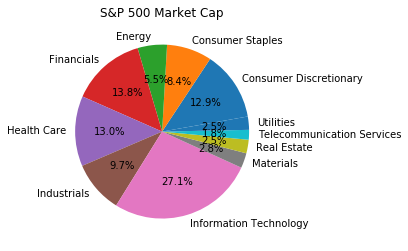

In [5]:
# Figure 1 - Pie chart

# create data series
Market_Cap = sector_df["Market Cap"]
Sectors = sector_df.index

# Plot
plt.pie(Market_Cap, labels=Sectors, startangle=10, autopct='%.1f%%')
plt.title('S&P 500 Market Cap')

In [7]:
# Sector Analysis:  Top Companies in S and P 500
# this part of the analysis will determine the top 4 companies in each of the top sectors in the S & P 500
# symbols will be a list of lists, with each sector occupying a row

# store the top 4 sectors in a list
top_four_sectors_array = top_4_market_cap_df.index

symbols = [] # initialize list to store symbols of the top 4 companies from each sector
market_cap_per_company = [] # initialize a list to show market cap for all 16 companies
# loop through each sector to find the top 4 companies
for asector in top_four_sectors_array:
    companies_in_sector_df = datahub_df.loc[datahub_df['Sector'] == asector]
    top_companies_in_sector_df = companies_in_sector_df.nlargest(4, 'Market Cap')  
    symbols.append(top_companies_in_sector_df['Symbol'].tolist()) # append the list to the list symbols
    market_cap_per_company.append(top_companies_in_sector_df['Market Cap'].tolist())

print(symbols)
print(market_cap_per_company)

# To access one symbol I will be using variables "i" and "j." This is a very important point.
# It will allow us to generate multiple charts. (i.e. symbols[i][j])

# ***Change i and j to show graph for individual stock you want to see, k for sector.
k=1
i=0
j=0

#controls which list we want to look in.


[['AAPL', 'GOOGL', 'GOOG', 'MSFT'], ['JPM', 'BAC', 'WFC', 'BRK.B'], ['JNJ', 'UNH', 'PFE', 'ABBV'], ['AMZN', 'HD', 'CMCSA', 'DIS']]
[[809508034020, 733823966137, 728535558140, 689978437468], [386613611000, 321478200969, 281463620775, 261401203633], [353062464971, 218834811333, 208505541949, 181386347059], [685873374731, 223378633329, 186476996883, 157817273295]]


In [5]:
# ALPHA VANTAGE API SCRAPING

# will need function, symbol, and api key in order to import the json from the api
url_alpha_vantage = "https://www.alphavantage.co/" 

# url variables
function = "TIME_SERIES_DAILY"
symbol = "MSFT"
outputsize = "full" # full or compact (100 latest vs all data)

# Following the query will show you a xml(?) page, which you should do because it is good for understanding.
# I've uncommented the print(query) command so you can click on the link and see for yourself (don't abuse Ram's key!)

# making the querying APIs a json so we can query four at once below in the group.
def url_response(ticker):
    query = url_alpha_vantage + "query?" + "function=" + function + "&symbol=" + ticker +"&outputsize=" + outputsize + "&apikey=" + av_key  
    url_response = requests.get(query).json()
    return url_response

print(symbols[k])


json_responses1 = []
for tickers in symbols[k]:
    response = url_response(tickers)
    json_responses1.append(response)
    
# pprint(json_responses1) #confirm that it works.
# pretty print the json
# print(json.dumps(url_response, indent=4, sort_keys=True))

['JPM', 'BAC', 'WFC', 'BRK.B']


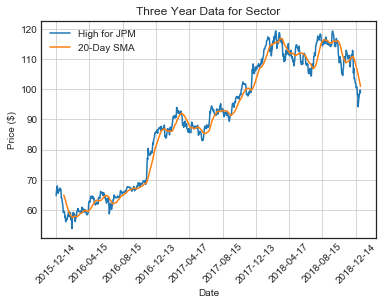

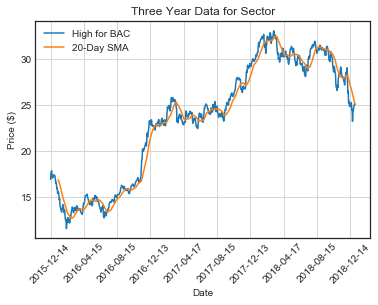

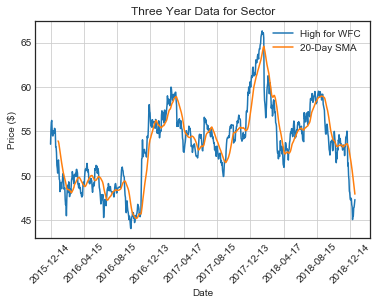

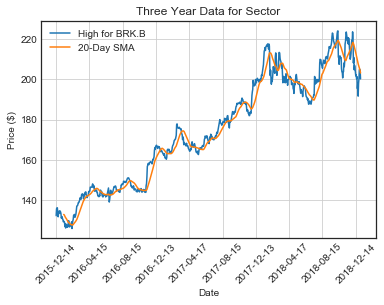

In [62]:

#ts_df2 = pd.DataFrame.from_dict(url_response2["Time Series (Daily)"])

# artifacts from testing (ignore unless you want to try things out yourself.)
# microsoft_df = pd.DataFrame.from_dict(url_response, orient = 'columns')
#microsoft_df = microsoft_df.tail(730)

ts_df = pd.DataFrame({'A' : []})

#create definition so we don't have to manipulate each stock time series.
def manipulation (ts_df):
# create a data frame from the json
# I'm renaming this thing two times to show the logic - we are getting three year data for one company, Microsoft.
# Then, we are accessing the Time Series (Daily) dict metadata (first out of five), then I am abbreviating it.
    timeseries_df = ts_df = pd.DataFrame.from_dict(json_responses1[j]["Time Series (Daily)"])
# Rename the index to actually be accurate.
    ts_df.index.name = "Date"
# only look at data from the past 3 years 
    ts_df = ts_df.T.head(810)
#sort so that the dates go from 2016 to 2019 instead of the reverse.
    ts_df = ts_df.loc[::-1,:]
    ts_df = ts_df.head(769)
    #display(ts_df)
# Rename columns so they don't look unprocessed and bad.
# create the dictionary to pass to the rename method.
    re_col = {"1. open": "Open", "2. high": "High", "3. low": "Low","4. close": "Close", "5. volume": "Volume"}
# baptize the columns.
    ts_df = ts_df.rename(columns = re_col)
    
    return ts_df
#display(ts_df.head(730)) #use to show the data we are plotting.
#begin visualization of stock

def SMA(ts_df):
    ts_df = manipulation(ts_df)
    ts_df["20 Day SMA"] = ts_df["High"].rolling(window=20).mean()
    #ts_df=ts_df.fillna(0)
    return (ts_df)


# RKY: See the note I made after print(symbols)
#Remember i=0
#j=1
def visualization (ts_df,i,j):
    colors = ["red","green","blue","orange"]
    #ts_df = manipulation(ts_df) 
    ts_df = SMA(ts_df)
    
    index = list(ts_df.index)
    vis_df = pd.DataFrame({f"High for {symbols[i][j]}":ts_df["High"],"20-Day SMA":ts_df["20 Day SMA"]}, index = index)
    vis_df = vis_df.astype(float)

    plt.style.use('seaborn-white')
    vis_df.plot(grid=True,title=f'Three Year Data for Sector', xticks=([w*7*12 for w in range(10)]),rot=45)
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.show()

    
while i < len(symbols):
    while j < len(symbols[0]):
        visualization(ts_df,k,j)
        j+=1
    i+=1


In [ ]:
# should only be shown once at the end of notebook